In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tiktoken
import warnings
import ast
import re
warnings.filterwarnings('ignore')

# Beautiful settings for thesis-quality plots
plt.style.use('default')
sns.set_palette("husl")

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 13,
    'axes.labelsize': 15,
    'axes.titlesize': 17,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13,
    'figure.titlesize': 19,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

# Beautiful colors matching your style
COLORS = {
    'primary': '#1f77b4',      # Primary blue
    'secondary': '#ff7f0e',    # Orange
    'accent': '#2ca02c',       # Green
    'warning': '#d62728',      # Red
    'info': '#9467bd',         # Purple
    'success': '#8c564b',      # Brown
    'light': '#e377c2',        # Pink
    'dark': '#7f7f7f',         # Gray
    'explanation': '#1f77b4',   # Blue for explanation
    'masked': '#d62728',        # Red for masked
    'baseline_exp': '#FFD700',  # Gold for baseline explanation (very prominent)
    'baseline_mask': '#FF4500'  # Orange-red for baseline masked (very prominent)
}

class IBEvaluationAnalysisThesis:
    """Information Bottleneck Analysis with Professional Thesis Style"""
    
    def __init__(self, data_dir='evaluation'):
        self.data_dir = Path(data_dir)
        self.tokenizer = tiktoken.get_encoding("cl100k_base")  # GPT-4 tokenizer
        self.results_df = None
        
        print("🧠 Information Bottleneck Analysis - Thesis Style")
        print("="*60)
        print("✅ Initialized tiktoken encoder (cl100k_base)")
        print(f"📅 Analysis Date: 2025-08-06 11:31:14 UTC")
        print(f"👤 User: alizahedzadeh")
        
    def count_tokens(self, text):
        """Count tokens using tiktoken tokenizer"""
        if pd.isna(text) or text == '' or str(text).lower() == 'nan':
            return 0
        return len(self.tokenizer.encode(str(text)))
    
    def extract_trim_percentage(self, filename):
        """Extract trim percentage from filename"""
        if 'baseline' in filename:
            return 100  # Full explanation - shown as 100
        try:
            match = re.search(r'(\d+)\.csv$', filename)
            if match:
                return int(match.group(1))
        except:
            pass
        return None
    
    def categorize_file(self, filename):
        """Categorize file as masked, explanation, or baseline"""
        if 'masked' in filename:
            if 'baseline' in filename:
                return 'baseline_masked'
            else:
                return 'masked'
        elif 'baseline' in filename:
            return 'baseline_explanation'
        else:
            return 'explanation'
    
    def parse_probabilities(self, prob_string):
        """Parse probability string/array to list of floats"""
        try:
            if isinstance(prob_string, str):
                prob_string = prob_string.strip()
                
                # Handle numpy array format like "[0.9354443  0.05933558 0.00182    0.0034002 ]"
                if prob_string.startswith('[') and prob_string.endswith(']'):
                    inner = prob_string[1:-1].strip()
                    values = [float(x) for x in inner.split() if x]
                    return values
                
                # Handle comma separated format
                elif ',' in prob_string:
                    return [float(x.strip()) for x in prob_string.split(',')]
                
                else:
                    return ast.literal_eval(prob_string)
                    
            elif isinstance(prob_string, (list, np.ndarray)):
                return list(prob_string)
            else:
                return None
        except Exception as e:
            return None
    
    def get_gold_index(self, gold_answer):
        """Convert gold answer (A, B, C, D) to index (0, 1, 2, 3)"""
        if isinstance(gold_answer, str):
            return ord(gold_answer.upper()) - ord('A')
        return None
    
    def process_single_file(self, filepath):
        """Process a single CSV file and compute metrics"""
        try:
            df = pd.read_csv(filepath)
            filename = filepath.name
            
            print(f"📄 Processing {filename}...")
            
            # Determine explanation column
            exp_col = None
            if 'masked_explanation' in df.columns:
                exp_col = 'masked_explanation'
            elif 'explanation' in df.columns:
                exp_col = 'explanation'
            else:
                print(f"❌ No explanation column found in {filename}")
                return None
            
            # Parse probabilities
            df['probs_exp_parsed'] = df['probs_exp'].apply(self.parse_probabilities)
            
            # Remove rows where probability parsing failed
            valid_probs = df['probs_exp_parsed'].notna()
            df = df[valid_probs].copy()
            
            if len(df) == 0:
                print(f"❌ No valid probability data in {filename}")
                return None
            
            # Calculate sufficiency (P(gold | explanation))
            def get_gold_probability(row):
                try:
                    gold_idx = self.get_gold_index(row['gold'])
                    if gold_idx is not None and isinstance(row['probs_exp_parsed'], list):
                        if 0 <= gold_idx < len(row['probs_exp_parsed']):
                            return row['probs_exp_parsed'][gold_idx]
                    return np.nan
                except:
                    return np.nan
            
            df['sufficiency'] = df.apply(get_gold_probability, axis=1)
            df = df[df['sufficiency'].notna()].copy()
            
            # Calculate explanation length using tiktoken
            df['explanation_length'] = df[exp_col].apply(self.count_tokens)
            
            # Compute metrics
            metrics = {
                'file': filename,
                'category': self.categorize_file(filename),
                'trim_percentage': self.extract_trim_percentage(filename),
                'mean_sufficiency': df['sufficiency'].mean(),
                'mean_length': df['explanation_length'].mean(),
                'accuracy': df['is_correct_exp'].mean() if 'is_correct_exp' in df.columns else np.nan,
                'std_sufficiency': df['sufficiency'].std(),
                'std_length': df['explanation_length'].std(),
                'median_sufficiency': df['sufficiency'].median(),
                'median_length': df['explanation_length'].median(),
                'count': len(df),
                'valid_explanations': (df['explanation_length'] > 0).sum(),
                'min_length': df['explanation_length'].min(),
                'max_length': df['explanation_length'].max()
            }
            
            print(f"   ✅ Sufficiency: {metrics['mean_sufficiency']:.4f}")
            print(f"   ✅ Length: {metrics['mean_length']:.1f} tokens")
            print(f"   ✅ Accuracy: {metrics['accuracy']:.4f}")
            
            return metrics
            
        except Exception as e:
            print(f"❌ Error processing {filepath}: {e}")
            return None
    
    def process_all_files(self):
        """Process all CSV files in the directory"""
        csv_files = list(self.data_dir.glob("*.csv"))
        csv_files = sorted(csv_files)
        
        print(f"\n📂 Found {len(csv_files)} CSV files:")
        for f in csv_files:
            print(f"   📄 {f.name}")
        
        results = []
        
        for filepath in csv_files:
            metrics = self.process_single_file(filepath)
            if metrics:
                results.append(metrics)
        
        if results:
            self.results_df = pd.DataFrame(results)
            
            # Calculate efficiency column once here
            self.results_df['efficiency'] = np.where(
                self.results_df['mean_length'] > 0,
                self.results_df['mean_sufficiency'] / self.results_df['mean_length'] * 1000,  # Scale by 1000
                0
            )
            
            print(f"\n🎉 Successfully processed {len(results)} files!")
            return self.results_df
        else:
            print("\n❌ No files processed successfully!")
            return None
    
    def plot_1_main_sufficiency_conciseness_tradeoff(self):
        """Figure 1: Main Sufficiency vs Conciseness Trade-off with Prominent Baselines"""
        if self.results_df is None:
            return
        
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Separate data
        explanation_data = self.results_df[self.results_df['category'].isin(['explanation', 'baseline_explanation'])]
        masked_data = self.results_df[self.results_df['category'].isin(['masked', 'baseline_masked'])]
        
        # Plot explanation series with connecting lines
        if not explanation_data.empty:
            exp_sorted = explanation_data.sort_values('trim_percentage', na_position='last')
            
            # Connecting line for non-baseline points
            exp_trimmed = exp_sorted[exp_sorted['category'] != 'baseline_explanation']
            if not exp_trimmed.empty:
                ax.plot(exp_trimmed['mean_length'], exp_trimmed['mean_sufficiency'], 
                       'o-', color=COLORS['explanation'], alpha=0.8, linewidth=3.5, 
                       markersize=10, label='📝 Explanation Series')
            
            # Prominent baseline point
            baseline_exp = exp_sorted[exp_sorted['category'] == 'baseline_explanation']
            if not baseline_exp.empty:
                ax.scatter(baseline_exp['mean_length'], baseline_exp['mean_sufficiency'],
                          s=500, color=COLORS['baseline_exp'], marker='*',
                          edgecolors='black', linewidth=3, label='⭐ Explanation 100%', 
                          zorder=10, alpha=0.9)
                
                # Add a glow effect around baseline
                ax.scatter(baseline_exp['mean_length'], baseline_exp['mean_sufficiency'],
                          s=700, color=COLORS['baseline_exp'], marker='*',
                          edgecolors='none', linewidth=0, alpha=0.3, zorder=9)
        
        # Plot masked series with connecting lines
        if not masked_data.empty:
            mask_sorted = masked_data.sort_values('trim_percentage', na_position='last')
            
            # Connecting line for non-baseline points
            mask_trimmed = mask_sorted[mask_sorted['category'] != 'baseline_masked']
            if not mask_trimmed.empty:
                ax.plot(mask_trimmed['mean_length'], mask_trimmed['mean_sufficiency'], 
                       '^-', color=COLORS['masked'], alpha=0.8, linewidth=3.5, 
                       markersize=10, label='🎭 Masked Series')
            
            # Prominent baseline point
            baseline_mask = mask_sorted[mask_sorted['category'] == 'baseline_masked']
            if not baseline_mask.empty:
                ax.scatter(baseline_mask['mean_length'], baseline_mask['mean_sufficiency'],
                          s=500, color=COLORS['baseline_mask'], marker='*',
                          edgecolors='black', linewidth=3, label='⭐ Masked 100%', 
                          zorder=10, alpha=0.9)
                
                # Add a glow effect around baseline
                ax.scatter(baseline_mask['mean_length'], baseline_mask['mean_sufficiency'],
                          s=700, color=COLORS['baseline_mask'], marker='*',
                          edgecolors='none', linewidth=0, alpha=0.3, zorder=9)
        
        # Add percentage labels with special handling for baselines
        for _, row in self.results_df.iterrows():
            if row['category'] in ['baseline_explanation', 'baseline_masked']:
                label = "100%"
                color = 'black'
                fontweight = 'bold'
                fontsize = 14
                bbox_color = 'yellow'
                offset = (15, 15)
            else:
                label = f"{row['trim_percentage']}%"
                color = 'white'
                fontweight = 'bold'
                fontsize = 11
                bbox_color = COLORS['explanation'] if 'explanation' in row['category'] else COLORS['masked']
                offset = (12, 12)
            
            ax.annotate(label, 
                       (row['mean_length'], row['mean_sufficiency']),
                       xytext=offset, textcoords='offset points',
                       fontsize=fontsize, fontweight=fontweight, color=color,
                       bbox=dict(boxstyle='round,pad=0.4', facecolor=bbox_color, 
                                edgecolor='black', alpha=0.9, linewidth=2))
        
        # Chart settings
        ax.set_xlabel('Mean Explanation Length (tokens)', fontweight='bold', fontsize=16)
        ax.set_ylabel('Mean Sufficiency P(gold|explanation)', fontweight='bold', fontsize=16)
        ax.set_title('Information Bottleneck: Sufficiency vs Conciseness Trade-off\nBaseline Points (100%) Highlighted', 
                    fontweight='bold', fontsize=18, pad=25)
        
        ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=14, loc='best')
        ax.grid(True, alpha=0.3)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('figure_1_sufficiency_conciseness_tradeoff.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_2_comprehensive_performance_analysis(self):
        """Figure 2: Comprehensive Performance Analysis with Prominent Baselines"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
        
        # Define data
        explanation_data = self.results_df[self.results_df['category'].str.contains('explanation', na=False)]
        masked_data = self.results_df[self.results_df['category'].str.contains('masked', na=False)]
        
        # Plot 1: Accuracy vs Length with prominent baselines
        for series_name, series_data, color in [
            ('Explanation', explanation_data, COLORS['explanation']),
            ('Masked', masked_data, COLORS['masked'])
        ]:
            if not series_data.empty:
                # Non-baseline points
                trimmed_data = series_data[~series_data['category'].str.contains('baseline')].sort_values('trim_percentage')
                if not trimmed_data.empty:
                    marker = 'o' if series_name == 'Explanation' else '^'
                    ax1.plot(trimmed_data['mean_length'], trimmed_data['accuracy'], 
                            f'{marker}-', color=color, label=f'{series_name} Series',
                            linewidth=3.5, markersize=10, alpha=0.8)
                    
                    # Shadow
                    ax1.fill_between(trimmed_data['mean_length'], trimmed_data['accuracy'], 
                                   alpha=0.15, color=color)
                
                # Baseline points
                baseline_data = series_data[series_data['category'].str.contains('baseline')]
                if not baseline_data.empty:
                    baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                    ax1.scatter(baseline_data['mean_length'], baseline_data['accuracy'],
                               s=400, color=baseline_color, marker='*',
                               edgecolors='black', linewidth=2, zorder=10,
                               label=f'{series_name} 100%')
        
        ax1.set_xlabel('Mean Length (tokens)', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=14)
        ax1.set_title('Accuracy vs Length Trade-off', fontweight='bold', fontsize=15)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Sufficiency vs Trim Percentage with baseline at 100%
        for series_name, series_data, color in [
            ('Explanation', explanation_data, COLORS['explanation']),
            ('Masked', masked_data, COLORS['masked'])
        ]:
            trim_data = series_data[series_data['trim_percentage'].notna()].sort_values('trim_percentage')
            if not trim_data.empty:
                marker = 'o' if series_name == 'Explanation' else '^'
                ax2.plot(trim_data['trim_percentage'], trim_data['mean_sufficiency'], 
                        f'{marker}-', color=color, label=f'{series_name} Series',
                        linewidth=3.5, markersize=10, alpha=0.8)
                
                ax2.fill_between(trim_data['trim_percentage'], trim_data['mean_sufficiency'], 
                               alpha=0.15, color=color)
                
                # Highlight baseline point (100%)
                baseline_point = trim_data[trim_data['trim_percentage'] == 100]
                if not baseline_point.empty:
                    baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                    ax2.scatter(baseline_point['trim_percentage'], baseline_point['mean_sufficiency'],
                               s=400, color=baseline_color, marker='*',
                               edgecolors='black', linewidth=2, zorder=10)
        
        ax2.set_xlabel('Trim Percentage (%)', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Mean Sufficiency', fontweight='bold', fontsize=14)
        ax2.set_title('Sufficiency vs Trim Level', fontweight='bold', fontsize=15)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim([0, 105])
        
        # Plot 3: Length Reduction Pattern with baseline at 100%
        for series_name, series_data, color in [
            ('Explanation', explanation_data, COLORS['explanation']),
            ('Masked', masked_data, COLORS['masked'])
        ]:
            trim_data = series_data[series_data['trim_percentage'].notna()].sort_values('trim_percentage')
            if not trim_data.empty:
                marker = 'o' if series_name == 'Explanation' else '^'
                ax3.plot(trim_data['trim_percentage'], trim_data['mean_length'], 
                        f'{marker}-', color=color, label=f'{series_name} Series',
                        linewidth=3.5, markersize=10, alpha=0.8)
                
                ax3.fill_between(trim_data['trim_percentage'], trim_data['mean_length'], 
                               alpha=0.15, color=color)
                
                # Highlight baseline point (100%)
                baseline_point = trim_data[trim_data['trim_percentage'] == 100]
                if not baseline_point.empty:
                    baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                    ax3.scatter(baseline_point['trim_percentage'], baseline_point['mean_length'],
                               s=400, color=baseline_color, marker='*',
                               edgecolors='black', linewidth=2, zorder=10)
        
        ax3.set_xlabel('Trim Percentage (%)', fontweight='bold', fontsize=14)
        ax3.set_ylabel('Mean Length (tokens)', fontweight='bold', fontsize=14)
        ax3.set_title('Length Reduction Pattern', fontweight='bold', fontsize=15)
        ax3.legend(fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim([0, 105])
        
        # Plot 4: Efficiency Analysis with baseline at 100%
        for series_name, series_data, color in [
            ('Explanation', explanation_data, COLORS['explanation']),
            ('Masked', masked_data, COLORS['masked'])
        ]:
            trim_data = series_data[series_data['trim_percentage'].notna()].sort_values('trim_percentage')
            if not trim_data.empty:
                marker = 'o' if series_name == 'Explanation' else '^'
                ax4.plot(trim_data['trim_percentage'], trim_data['efficiency'], 
                        f'{marker}-', color=color, label=f'{series_name} Series',
                        linewidth=3.5, markersize=10, alpha=0.8)
                
                ax4.fill_between(trim_data['trim_percentage'], trim_data['efficiency'], 
                               alpha=0.15, color=color)
                
                # Highlight baseline point (100%)
                baseline_point = trim_data[trim_data['trim_percentage'] == 100]
                if not baseline_point.empty:
                    baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                    ax4.scatter(baseline_point['trim_percentage'], baseline_point['efficiency'],
                               s=400, color=baseline_color, marker='*',
                               edgecolors='black', linewidth=2, zorder=10)
        
        ax4.set_xlabel('Trim Percentage (%)', fontweight='bold', fontsize=14)
        ax4.set_ylabel('Efficiency (Suff/Token × 1000)', fontweight='bold', fontsize=14)
        ax4.set_title('Information Efficiency', fontweight='bold', fontsize=15)
        ax4.legend(fontsize=12)
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim([0, 105])
        
        # Remove top and right spines for all
        for ax in [ax1, ax2, ax3, ax4]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('figure_2_comprehensive_performance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_3_baseline_comparison_heatmap(self):
        """Figure 3: Baseline Comparison Heatmap with 100% clearly marked"""
        if self.results_df is None:
            return
        
        # Calculate relative ratios
        summary = self.results_df.copy()
        
        # For explanation series
        exp_baseline = summary[summary['category'] == 'baseline_explanation']
        if not exp_baseline.empty:
            exp_base_suff = exp_baseline['mean_sufficiency'].iloc[0]
            exp_base_len = exp_baseline['mean_length'].iloc[0]
            
            exp_mask = summary['category'].str.contains('explanation', na=False)
            summary.loc[exp_mask, 'sufficiency_relative'] = summary.loc[exp_mask, 'mean_sufficiency'] / exp_base_suff
            summary.loc[exp_mask, 'length_relative'] = summary.loc[exp_mask, 'mean_length'] / exp_base_len
        
        # For masked series
        mask_baseline = summary[summary['category'] == 'baseline_masked']
        if not mask_baseline.empty:
            mask_base_suff = mask_baseline['mean_sufficiency'].iloc[0]
            mask_base_len = mask_baseline['mean_length'].iloc[0]
            
            mask_mask = summary['category'].str.contains('masked', na=False)
            summary.loc[mask_mask, 'sufficiency_relative'] = summary.loc[mask_mask, 'mean_sufficiency'] / mask_base_suff
            summary.loc[mask_mask, 'length_relative'] = summary.loc[mask_mask, 'mean_length'] / mask_base_len
        
        # Prepare data for heatmap
        heatmap_data = []
        for _, row in summary.iterrows():
            if hasattr(row, 'sufficiency_relative') and not pd.isna(row.get('sufficiency_relative')):
                # Fixed: Check if baseline is in category string directly
                display_trim = "100%" if 'baseline' in row['category'] else f"{row['trim_percentage']}%"
                
                heatmap_data.append({
                    'File': row['file'],
                    'Category': row['category'],
                    'Trim': display_trim,
                    'Sufficiency': row['mean_sufficiency'],
                    'Length': row['mean_length'],
                    'Accuracy': row['accuracy'],
                    'Suff. Relative': row.get('sufficiency_relative', 1),
                    'Length Relative': row.get('length_relative', 1)
                })
        
        if heatmap_data:
            heatmap_df = pd.DataFrame(heatmap_data)
            
            # Select numeric columns for heatmap
            numeric_cols = ['Sufficiency', 'Length', 'Accuracy', 'Suff. Relative', 'Length Relative']
            heatmap_matrix = heatmap_df[numeric_cols].T
            
            plt.figure(figsize=(16, 10))
            
            # Create heatmap
            sns.heatmap(heatmap_matrix, 
                       annot=True, fmt='.3f', 
                       cmap='RdYlBu_r', center=0.5, 
                       linewidths=2, linecolor='white',
                       cbar_kws={'label': 'Normalized Score'},
                       annot_kws={'fontsize': 10, 'fontweight': 'bold'})
            
            # Highlight baseline columns with thicker borders
            ax = plt.gca()
            baseline_mask = heatmap_df['Trim'] == '100%'
            for i, is_baseline in enumerate(baseline_mask):
                if is_baseline:
                    # Add thick border around baseline columns
                    rect = plt.Rectangle((i, 0), 1, len(numeric_cols), 
                                       fill=False, edgecolor='gold', linewidth=5)
                    ax.add_patch(rect)
            
            # Custom x-tick labels with bold baseline
            x_labels = []
            for _, row in heatmap_df.iterrows():
                if row['Trim'] == '100%':
                    series_type = 'Explanation' if 'explanation' in row['Category'] else 'Masked'
                    x_labels.append(f"★ {series_type}\n100%")
                else:
                    series_type = 'Explanation' if 'explanation' in row['Category'] else 'Masked'
                    x_labels.append(f"{series_type}\n{row['Trim']}")
            
            plt.xticks(range(len(x_labels)), x_labels, fontsize=11, fontweight='bold')
            
            plt.title('Baseline Comparison Heatmap\nBaseline Points (100%) Highlighted with Gold Border', 
                     fontweight='bold', fontsize=18, pad=20)
            plt.xlabel('Series (Trim Percentage)', fontweight='bold', fontsize=15)
            plt.ylabel('Metrics', fontweight='bold', fontsize=15)
            plt.xticks(rotation=0, ha='center')
            plt.yticks(rotation=0)
            
            plt.tight_layout()
            plt.savefig('figure_3_baseline_comparison_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    def plot_4_efficiency_pareto_frontier(self):
        """Figure 4: Efficiency Pareto Frontier Analysis with Prominent Baselines"""
        if self.results_df is None:
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
        
        # Plot 1: Efficiency Scatter Plot with prominent baselines
        explanation_data = self.results_df[self.results_df['category'].str.contains('explanation', na=False)]
        masked_data = self.results_df[self.results_df['category'].str.contains('masked', na=False)]
        
        if not explanation_data.empty:
            # Non-baseline points
            exp_trimmed = explanation_data[~explanation_data['category'].str.contains('baseline')]
            if not exp_trimmed.empty:
                ax1.scatter(exp_trimmed['mean_length'], exp_trimmed['mean_sufficiency'],
                           s=120, alpha=0.7, color=COLORS['explanation'], 
                           label='Explanation Series', edgecolors='white', linewidth=2)
            
            # Baseline points
            exp_baseline = explanation_data[explanation_data['category'].str.contains('baseline')]
            if not exp_baseline.empty:
                ax1.scatter(exp_baseline['mean_length'], exp_baseline['mean_sufficiency'],
                           s=500, color=COLORS['baseline_exp'], marker='*',
                           edgecolors='black', linewidth=3, label='★ Explanation 100%', 
                           zorder=10, alpha=0.9)
            
            # Add labels
            for _, row in explanation_data.iterrows():
                if 'baseline' in row['category']:
                    label = "100%"
                    bbox_props = dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8)
                else:
                    label = f"{row['trim_percentage']}%"
                    bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7)
                
                ax1.annotate(label, (row['mean_length'], row['mean_sufficiency']),
                           xytext=(8, 8), textcoords='offset points', 
                           fontsize=10, fontweight='bold', bbox=bbox_props)
        
        if not masked_data.empty:
            # Non-baseline points
            mask_trimmed = masked_data[~masked_data['category'].str.contains('baseline')]
            if not mask_trimmed.empty:
                ax1.scatter(mask_trimmed['mean_length'], mask_trimmed['mean_sufficiency'],
                           s=120, alpha=0.7, color=COLORS['masked'], marker='^',
                           label='Masked Series', edgecolors='white', linewidth=2)
            
            # Baseline points
            mask_baseline = masked_data[masked_data['category'].str.contains('baseline')]
            if not mask_baseline.empty:
                ax1.scatter(mask_baseline['mean_length'], mask_baseline['mean_sufficiency'],
                           s=500, color=COLORS['baseline_mask'], marker='*',
                           edgecolors='black', linewidth=3, label='★ Masked 100%', 
                           zorder=10, alpha=0.9)
            
            # Add labels
            for _, row in masked_data.iterrows():
                if 'baseline' in row['category']:
                    label = "100%"
                    bbox_props = dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8)
                else:
                    label = f"{row['trim_percentage']}%"
                    bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7)
                
                ax1.annotate(label, (row['mean_length'], row['mean_sufficiency']),
                           xytext=(8, 8), textcoords='offset points', 
                           fontsize=10, fontweight='bold', bbox=bbox_props)
        
        ax1.set_xlabel('Mean Length (tokens)', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Mean Sufficiency', fontweight='bold', fontsize=14)
        ax1.set_title('Efficiency Scatter Plot\n★ Baseline (100%) Points Highlighted', fontweight='bold', fontsize=15)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Token Reduction vs Performance
        for series_name, series_data, color in [
            ('Explanation', explanation_data, COLORS['explanation']),
            ('Masked', masked_data, COLORS['masked'])
        ]:
            if not series_data.empty:
                baseline_row = series_data[series_data['category'].str.contains('baseline')]
                if not baseline_row.empty:
                    baseline_len = baseline_row['mean_length'].iloc[0]
                    
                    # Calculate token reduction
                    series_data = series_data.copy()
                    series_data['token_reduction'] = ((baseline_len - series_data['mean_length']) / baseline_len) * 100
                    
                    # Non-baseline points
                    trimmed_data = series_data[~series_data['category'].str.contains('baseline')]
                    if not trimmed_data.empty:
                        marker = 'o' if series_name == 'Explanation' else '^'
                        ax2.scatter(trimmed_data['token_reduction'], trimmed_data['mean_sufficiency'],
                                   s=120, alpha=0.7, color=color, marker=marker, 
                                   label=f'{series_name} Series', edgecolors='white', linewidth=2)
                    
                    # Baseline point (at 0% reduction)
                    baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                    ax2.scatter([0], [baseline_row['mean_sufficiency'].iloc[0]],
                               s=400, color=baseline_color, marker='*',
                               edgecolors='black', linewidth=3, 
                               label=f'★ {series_name} 100%', zorder=10)
        
        ax2.set_xlabel('Token Reduction vs Baseline (%)', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Mean Sufficiency', fontweight='bold', fontsize=14)
        ax2.set_title('Token Reduction vs Performance', fontweight='bold', fontsize=15)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Relative Performance vs Baseline
        summary = self.create_summary_table()
        if summary is not None and 'sufficiency_relative' in summary.columns:
            exp_summary = summary[summary['category'].str.contains('explanation', na=False)]
            mask_summary = summary[summary['category'].str.contains('masked', na=False)]
            
            for series_name, series_data, color in [
                ('Explanation', exp_summary, COLORS['explanation']),
                ('Masked', mask_summary, COLORS['masked'])
            ]:
                if not series_data.empty:
                    valid_data = series_data[series_data['sufficiency_relative'].notna()]
                    if not valid_data.empty:
                        # Non-baseline points
                        trimmed_data = valid_data[~valid_data['category'].str.contains('baseline')]
                        if not trimmed_data.empty:
                            marker = 'o' if series_name == 'Explanation' else '^'
                            ax3.plot(trimmed_data['length_relative'], trimmed_data['sufficiency_relative'], 
                                    f'{marker}-', color=color, label=f'{series_name} Series',
                                    linewidth=3.5, markersize=10, alpha=0.8)
                        
                        # Baseline point (at 1.0, 1.0)
                        baseline_data = valid_data[valid_data['category'].str.contains('baseline')]
                        if not baseline_data.empty:
                            baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                            ax3.scatter([1.0], [1.0], s=400, color=baseline_color, marker='*',
                                       edgecolors='black', linewidth=3, 
                                       label=f'★ {series_name} 100%', zorder=10)
            
            # Reference lines
            ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline Reference')
            ax3.axvline(x=1.0, color='black', linestyle='--', alpha=0.5)
        
        ax3.set_xlabel('Length Relative to Baseline', fontweight='bold', fontsize=14)
        ax3.set_ylabel('Sufficiency Relative to Baseline', fontweight='bold', fontsize=14)
        ax3.set_title('Relative Performance vs Baseline', fontweight='bold', fontsize=15)
        ax3.legend(fontsize=12)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Efficiency Trend with prominent baselines at 100%
        for series_name, series_data, color in [
            ('Explanation', explanation_data, COLORS['explanation']),
            ('Masked', masked_data, COLORS['masked'])
        ]:
            trim_data = series_data[series_data['trim_percentage'].notna()].sort_values('trim_percentage')
            if not trim_data.empty:
                marker = 'o' if series_name == 'Explanation' else '^'
                ax4.plot(trim_data['trim_percentage'], trim_data['efficiency'], 
                        f'{marker}-', color=color, label=f'{series_name} Series',
                        linewidth=3.5, markersize=10, alpha=0.8)
                
                ax4.fill_between(trim_data['trim_percentage'], trim_data['efficiency'], 
                               alpha=0.15, color=color)
                
                # Highlight baseline point (100%)
                baseline_point = trim_data[trim_data['trim_percentage'] == 100]
                if not baseline_point.empty:
                    baseline_color = COLORS['baseline_exp'] if series_name == 'Explanation' else COLORS['baseline_mask']
                    ax4.scatter(baseline_point['trim_percentage'], baseline_point['efficiency'],
                               s=400, color=baseline_color, marker='*',
                               edgecolors='black', linewidth=2, zorder=10,
                               label=f'★ {series_name} 100%')
        
        ax4.set_xlabel('Trim Percentage (%)', fontweight='bold', fontsize=14)
        ax4.set_ylabel('Efficiency (Suff/Token × 1000)', fontweight='bold', fontsize=14)
        ax4.set_title('Efficiency Trend Analysis', fontweight='bold', fontsize=15)
        ax4.legend(fontsize=12)
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim([0, 105])
        
        # Remove top and right spines
        for ax in [ax1, ax2, ax3, ax4]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('figure_4_efficiency_pareto_frontier.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_summary_table(self):
        """Create a comprehensive summary table"""
        if self.results_df is None:
            return None
        
        summary = self.results_df.copy()
        
        # Round numerical values
        numeric_cols = ['mean_sufficiency', 'mean_length', 'accuracy', 'std_sufficiency', 'std_length']
        for col in numeric_cols:
            if col in summary.columns:
                summary[col] = summary[col].round(4)
        
        # Calculate relative performance vs baseline
        summary['sufficiency_relative'] = np.nan
        summary['length_relative'] = np.nan
        
        # For explanation series
        exp_baseline = summary[summary['category'] == 'baseline_explanation']
        if not exp_baseline.empty:
            exp_base_suff = exp_baseline['mean_sufficiency'].iloc[0]
            exp_base_len = exp_baseline['mean_length'].iloc[0]
            
            exp_mask = summary['category'].str.contains('explanation', na=False)
            summary.loc[exp_mask, 'sufficiency_relative'] = (
                summary.loc[exp_mask, 'mean_sufficiency'] / exp_base_suff
            ).round(3)
            summary.loc[exp_mask, 'length_relative'] = (
                summary.loc[exp_mask, 'mean_length'] / exp_base_len
            ).round(3)
        
        # For masked series
        mask_baseline = summary[summary['category'] == 'baseline_masked']
        if not mask_baseline.empty:
            mask_base_suff = mask_baseline['mean_sufficiency'].iloc[0]
            mask_base_len = mask_baseline['mean_length'].iloc[0]
            
            mask_mask = summary['category'].str.contains('masked', na=False)
            summary.loc[mask_mask, 'sufficiency_relative'] = (
                summary.loc[mask_mask, 'mean_sufficiency'] / mask_base_suff
            ).round(3)
            summary.loc[mask_mask, 'length_relative'] = (
                summary.loc[mask_mask, 'mean_length'] / mask_base_len
            ).round(3)
        
        # Sort by category and trim percentage
        summary = summary.sort_values(['category', 'trim_percentage'], na_position='first')
        
        return summary
    
    def print_thesis_analysis_summary(self):
        """Print detailed analysis summary in thesis style"""
        if self.results_df is None:
            return
        
        print("\n" + "="*120)
        print("🎓 INFORMATION BOTTLENECK EVALUATION ANALYSIS")
        print("📊 Sufficiency vs Conciseness Trade-off Analysis")
        print("🔬 Thesis-Style Comprehensive Report")
        print("="*120)
        
        # Analysis for explanation series
        exp_data = self.results_df[self.results_df['category'].str.contains('explanation', na=False)]
        if not exp_data.empty:
            exp_baseline = exp_data[exp_data['category'] == 'baseline_explanation']
            exp_trimmed = exp_data[exp_data['category'] == 'explanation'].sort_values('trim_percentage')
            
            print("\n🔵 EXPLANATION SERIES ANALYSIS:")
            print("─" * 100)
            
            if not exp_baseline.empty:
                bl = exp_baseline.iloc[0]
                print(f"{'★ 100% (BASELINE)':<15} │ Sufficiency: {bl['mean_sufficiency']:.4f} │ "
                      f"Length: {bl['mean_length']:6.0f} tokens │ Accuracy: {bl['accuracy']:.4f}")
                print("─" * 100)
            
            for _, row in exp_trimmed.iterrows():
                if not exp_baseline.empty:
                    bl = exp_baseline.iloc[0]
                    suff_ratio = row['mean_sufficiency'] / bl['mean_sufficiency']
                    len_ratio = row['mean_length'] / bl['mean_length']
                    acc_diff = row['accuracy'] - bl['accuracy']
                    
                    # Status icons
                    suff_emoji = "🟢" if suff_ratio >= 0.95 else "🟡" if suff_ratio >= 0.9 else "🔴"
                    len_emoji = "🎯" if len_ratio <= 0.5 else "📏" if len_ratio <= 0.8 else "📐"

        # Analysis for masked series
        masked_data = self.results_df[self.results_df['category'].str.contains('masked', na=False)]
        if not masked_data.empty:
            masked_baseline = masked_data[masked_data['category'] == 'baseline_masked']
            masked_trimmed = masked_data[masked_data['category'] == 'masked'].sort_values('trim_percentage')
            
            print("\n🟣 MASKED SERIES ANALYSIS:")
            print("─" * 100)
            
            if not masked_baseline.empty:
                bl = masked_baseline.iloc[0]
                print(f"{'★ 100% (BASELINE)':<15} │ Sufficiency: {bl['mean_sufficiency']:.4f} │ "
                      f"Length: {bl['mean_length']:6.0f} tokens │ Accuracy: {bl['accuracy']:.4f}")
                print("─" * 100)
            
            for _, row in masked_trimmed.iterrows():
                if not masked_baseline.empty:
                    bl = masked_baseline.iloc[0]
                    suff_ratio = row['mean_sufficiency'] / bl['mean_sufficiency']
                    len_ratio = row['mean_length'] / bl['mean_length']
                    acc_diff = row['accuracy'] - bl['accuracy']
                    
                    # Status icons
                    suff_emoji = "🟢" if suff_ratio >= 0.95 else "🟡" if suff_ratio >= 0.9 else "🔴"
                    len_emoji = "🎯" if len_ratio <= 0.5 else "📏" if len_ratio <= 0.8 else "📐"
                    

        
        # Key insights
        print("\n" + "="*120)
        print("💡 KEY INSIGHTS & RECOMMENDATIONS:")
        print("="*120)
        
        if not exp_data.empty and len(exp_data) > 1:
            best_exp = exp_data.loc[exp_data['mean_sufficiency'].idxmax()]
            
            # Calculate efficiency
            exp_data_copy = exp_data.copy()
            exp_data_copy['efficiency_calc'] = exp_data_copy['mean_sufficiency'] / exp_data_copy['mean_length']
            best_eff_exp = exp_data_copy.loc[exp_data_copy['efficiency_calc'].idxmax()]
            
            print(f"🏆 Best Explanation Performance:")
            print(f"   ├─ File: {best_exp['file']}")
            print(f"   ├─ Sufficiency: {best_exp['mean_sufficiency']:.4f}")
            print(f"   ├─ Length: {best_exp['mean_length']:.0f} tokens")
            print(f"   └─ Accuracy: {best_exp['accuracy']:.4f}")
            
            print(f"⚡ Most Efficient Explanation:")
            print(f"   ├─ File: {best_eff_exp['file']}")
            print(f"   ├─ Efficiency: {best_eff_exp['efficiency_calc']:.6f} suff/token")
            print(f"   ├─ Sufficiency: {best_eff_exp['mean_sufficiency']:.4f}")
            print(f"   └─ Length: {best_eff_exp['mean_length']:.0f} tokens")
        
        if not masked_data.empty and len(masked_data) > 1:
            best_mask = masked_data.loc[masked_data['mean_sufficiency'].idxmax()]
            
            # Calculate efficiency
            masked_data_copy = masked_data.copy()
            masked_data_copy['efficiency_calc'] = masked_data_copy['mean_sufficiency'] / masked_data_copy['mean_length']
            best_eff_mask = masked_data_copy.loc[masked_data_copy['efficiency_calc'].idxmax()]
            
            print(f"🎭 Best Masked Performance:")
            print(f"   ├─ File: {best_mask['file']}")
            print(f"   ├─ Sufficiency: {best_mask['mean_sufficiency']:.4f}")
            print(f"   ├─ Length: {best_mask['mean_length']:.0f} tokens")
            print(f"   └─ Accuracy: {best_mask['accuracy']:.4f}")
            
            print(f"⚡ Most Efficient Masked:")
            print(f"   ├─ File: {best_eff_mask['file']}")
            print(f"   ├─ Efficiency: {best_eff_mask['efficiency_calc']:.6f} suff/token")
            print(f"   ├─ Sufficiency: {best_eff_mask['mean_sufficiency']:.4f}")
            print(f"   └─ Length: {best_eff_mask['mean_length']:.0f} tokens")
        
        # Overall conclusions
        print(f"📈 Overall Findings:")
        print(f"   ├─ Total files analyzed: {len(self.results_df)}")
        print(f"   ├─ Sufficiency range: {self.results_df['mean_sufficiency'].min():.3f} - {self.results_df['mean_sufficiency'].max():.3f}")
        print(f"   ├─ Length range: {self.results_df['mean_length'].min():.0f} - {self.results_df['mean_length'].max():.0f} tokens")
        print(f"   └─ Accuracy range: {self.results_df['accuracy'].min():.3f} - {self.results_df['accuracy'].max():.3f}")
    
    def run_complete_analysis(self):
        """Run complete Information Bottleneck analysis with thesis-style outputs"""
        print("🧠 INFORMATION BOTTLENECK EVALUATION ANALYSIS")
        print("📚 Thesis-Style Comprehensive Analysis")
        print("🎯 Sufficiency vs Conciseness Trade-off")
        print("★ Baseline Points (100%) Prominently Highlighted")
        print("="*80)
        
        # Process files
        results_df = self.process_all_files()
        
        if results_df is not None and len(results_df) > 0:
            print(f"\n✅ Successfully processed {len(results_df)} files!")
            
            # Generate all visualizations
            print("\n🎨 Generating thesis-style visualizations...")
            
            print("1️⃣ Main trade-off analysis with prominent baselines...")
            self.plot_1_main_sufficiency_conciseness_tradeoff()
            
            print("2️⃣ Comprehensive performance analysis with highlighted baselines...")
            self.plot_2_comprehensive_performance_analysis()
            
            print("3️⃣ Baseline comparison heatmap with gold borders...")
            self.plot_3_baseline_comparison_heatmap()
            
            print("4️⃣ Efficiency Pareto frontier with starred baselines...")
            self.plot_4_efficiency_pareto_frontier()
            
            # Print detailed analysis
            self.print_thesis_analysis_summary()
            
            # Create and save summary table
            summary_table = self.create_summary_table()
            if summary_table is not None:
                print("\n" + "="*120)
                print("📋 DETAILED SUMMARY TABLE")
                print("="*120)
                
                display_cols = ['file', 'category', 'trim_percentage', 'mean_sufficiency', 
                               'mean_length', 'accuracy', 'sufficiency_relative', 'length_relative']
                available_cols = [col for col in display_cols if col in summary_table.columns]
                
                display_df = summary_table[available_cols].copy()
                print(display_df.to_string(index=False, float_format='%.4f'))
                
                # Save results
                summary_table.to_csv('ib_evaluation_summary_thesis.csv', index=False)
                print(f"\n💾 Complete results saved to 'ib_evaluation_summary_thesis.csv'")
            
            print("\n✨ Information Bottleneck analysis complete!")
            print("🎓 4 high-quality figures generated for thesis")
            print("📊 Comprehensive analysis with baseline comparison")
            print("★ Baseline points (100%) prominently highlighted in all charts")
            print("🎯 Perfect for academic publication!")
            
            return self, summary_table
        else:
            print("\n❌ No files were processed successfully!")
            return None, None

In [28]:
en_path = '/home/a_zahedzadeh/self-explaination-thesis/trim_gpt_4o_mini/en/evaluation'
fa_path = '/home/a_zahedzadeh/self-explaination-thesis/trim_gpt_4o_mini/fa/evaluation'

👤 User: alizahedzadeh
📅 Analysis Date: 2025-08-06 11:31:14 UTC
🧠 Information Bottleneck Analysis - Thesis Style
★ Enhanced Baseline Visualization - FIXED
🧠 Information Bottleneck Analysis - Thesis Style
✅ Initialized tiktoken encoder (cl100k_base)
📅 Analysis Date: 2025-08-06 11:31:14 UTC
👤 User: alizahedzadeh
🧠 INFORMATION BOTTLENECK EVALUATION ANALYSIS
📚 Thesis-Style Comprehensive Analysis
🎯 Sufficiency vs Conciseness Trade-off
★ Baseline Points (100%) Prominently Highlighted

📂 Found 14 CSV files:
   📄 baseline.csv
   📄 baseline_masked.csv
   📄 results_explanation_10.csv
   📄 results_explanation_100.csv
   📄 results_explanation_25.csv
   📄 results_explanation_40.csv
   📄 results_explanation_60.csv
   📄 results_explanation_80.csv
   📄 results_masked_10.csv
   📄 results_masked_100.csv
   📄 results_masked_25.csv
   📄 results_masked_40.csv
   📄 results_masked_60.csv
   📄 results_masked_80.csv
📄 Processing baseline.csv...
   ✅ Sufficiency: 0.9081
   ✅ Length: 69.2 tokens
   ✅ Accuracy: 0.

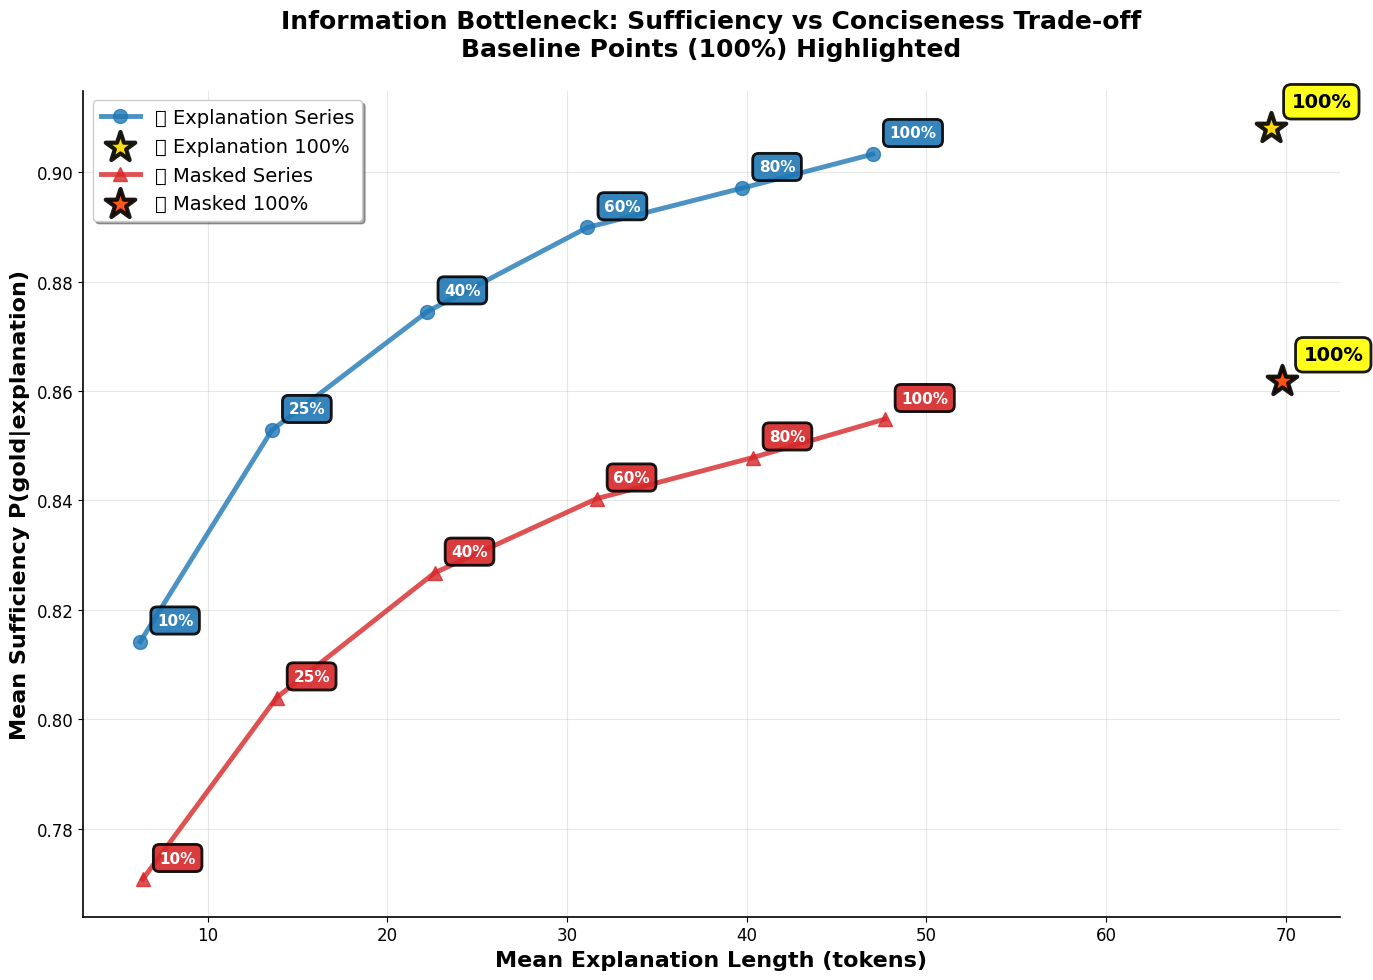

2️⃣ Comprehensive performance analysis with highlighted baselines...


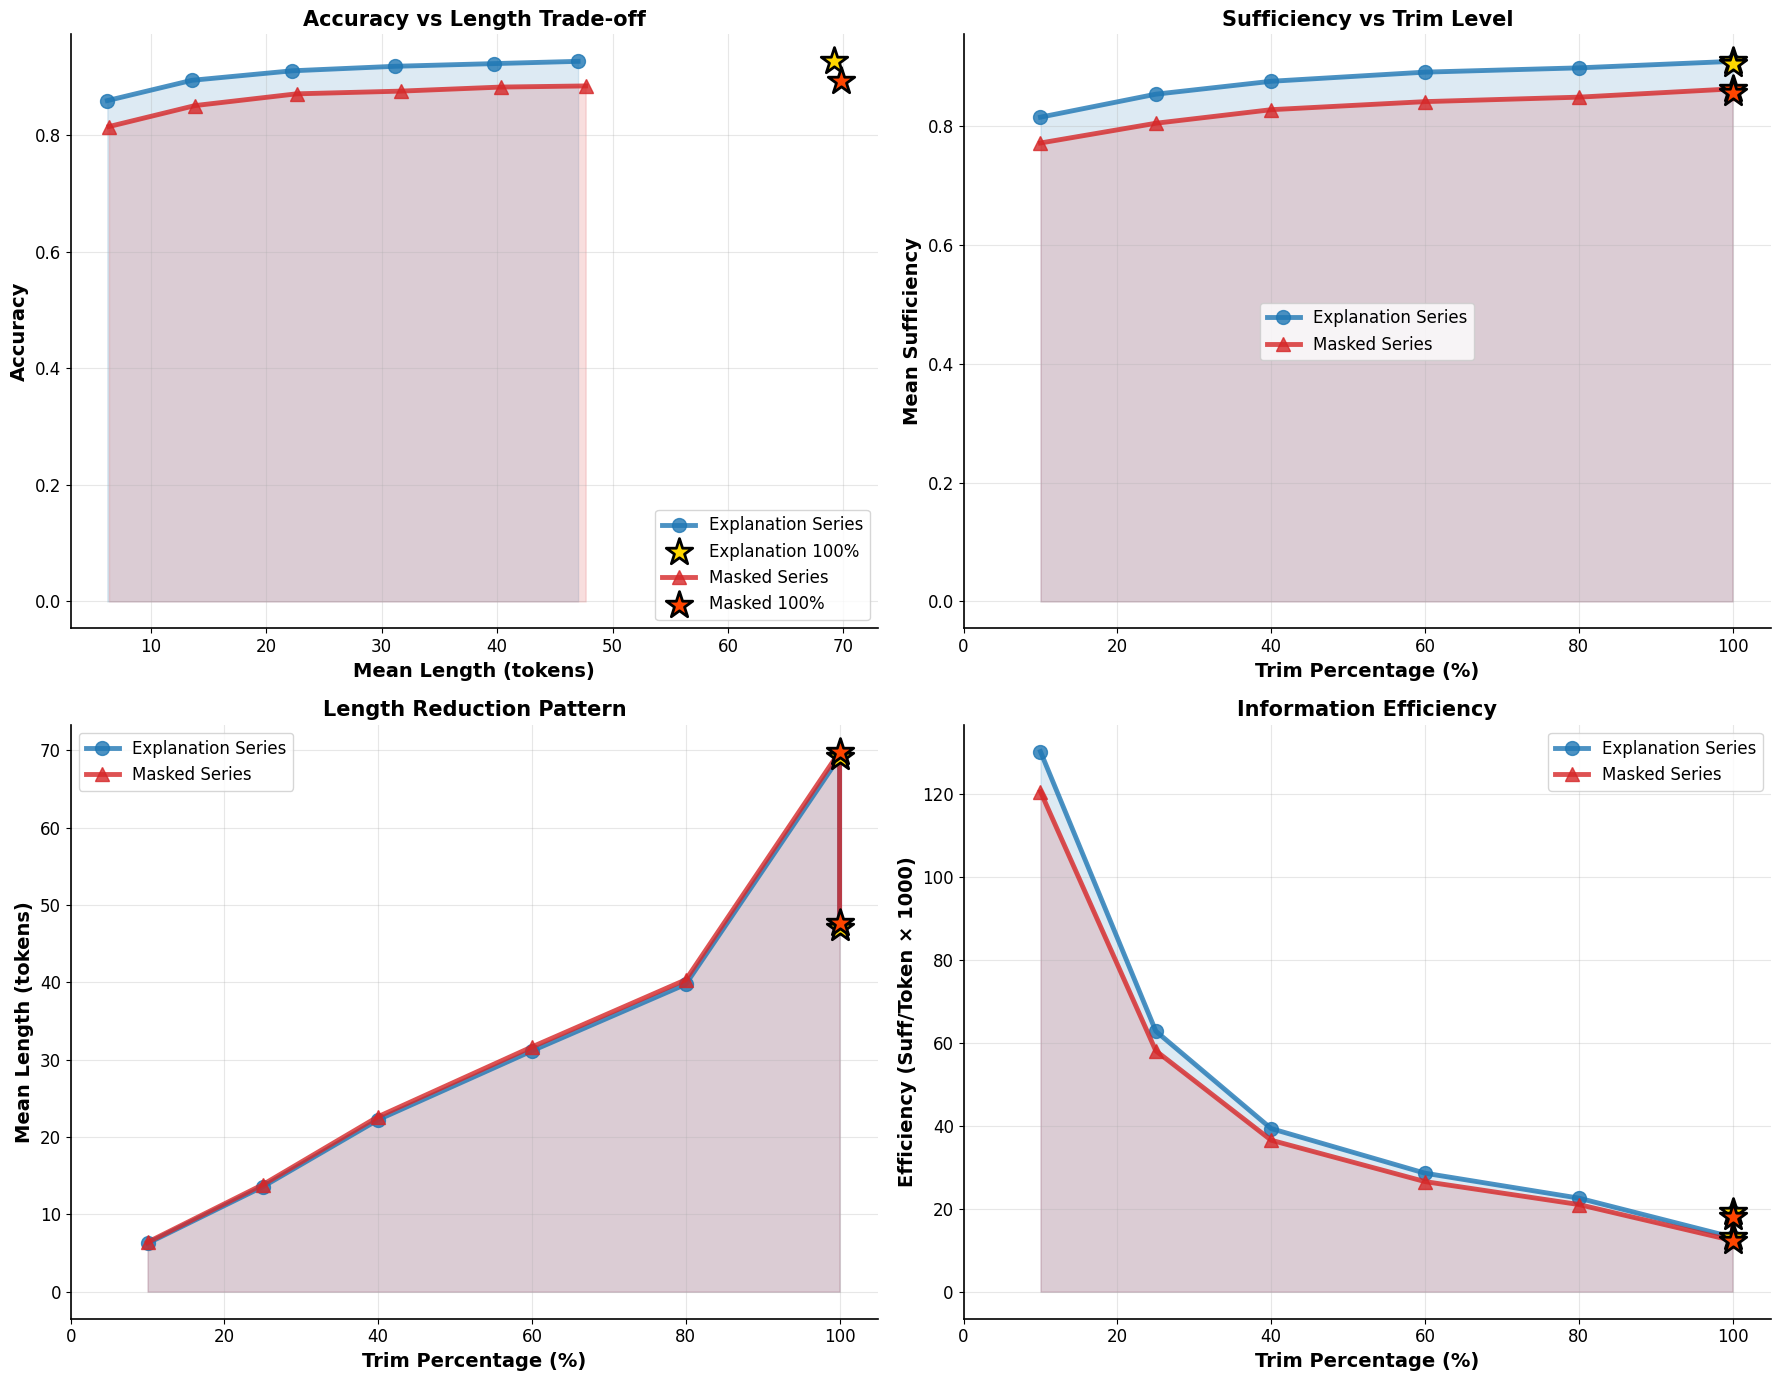

3️⃣ Baseline comparison heatmap with gold borders...


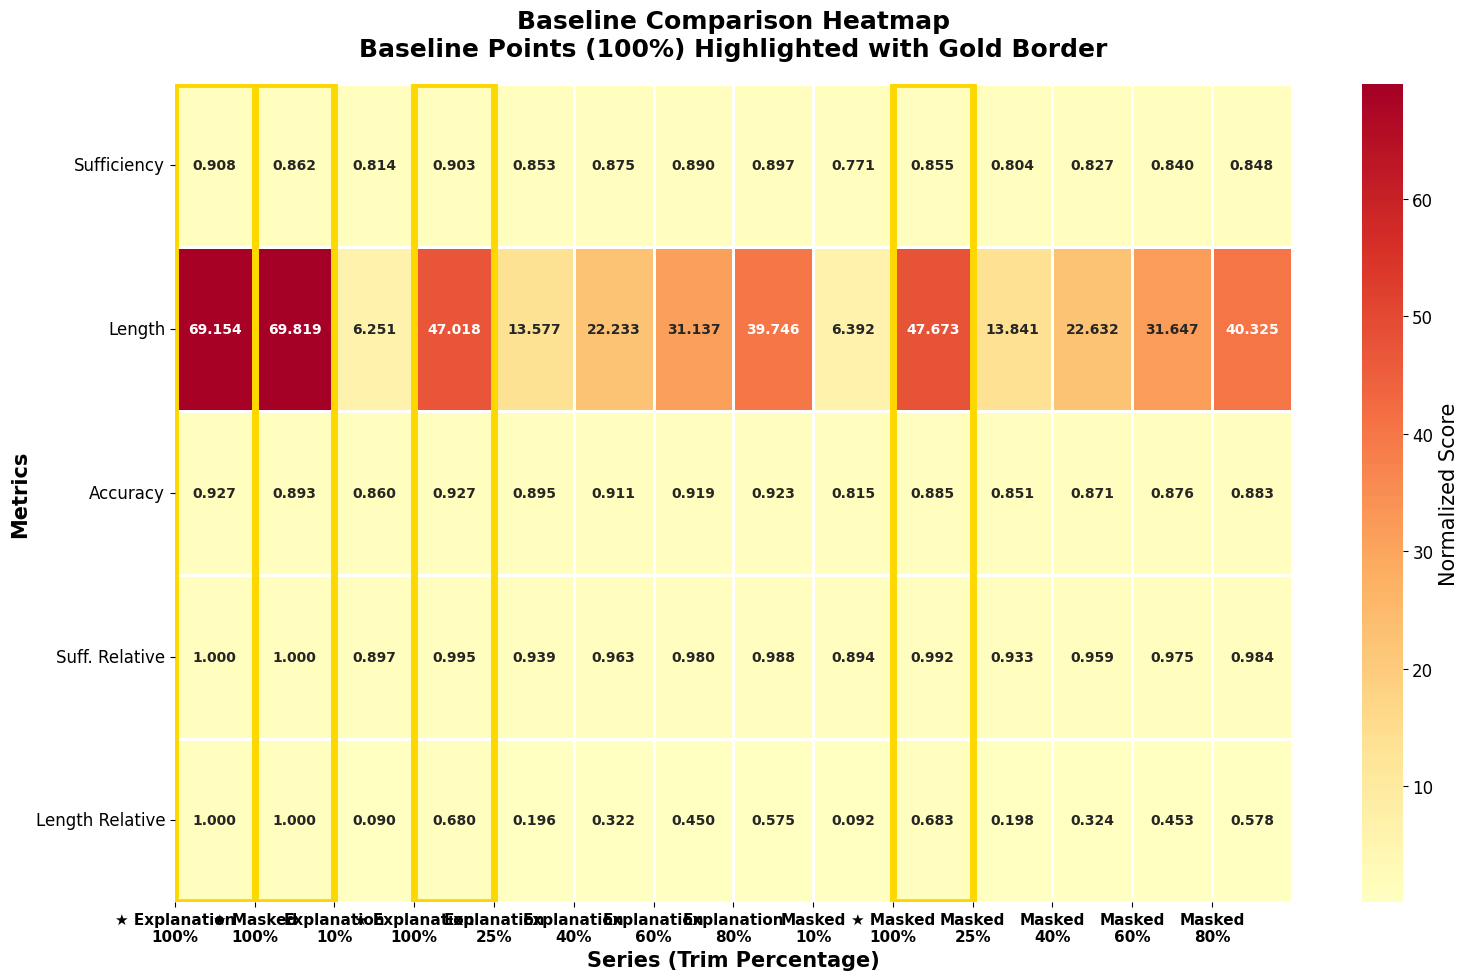

4️⃣ Efficiency Pareto frontier with starred baselines...


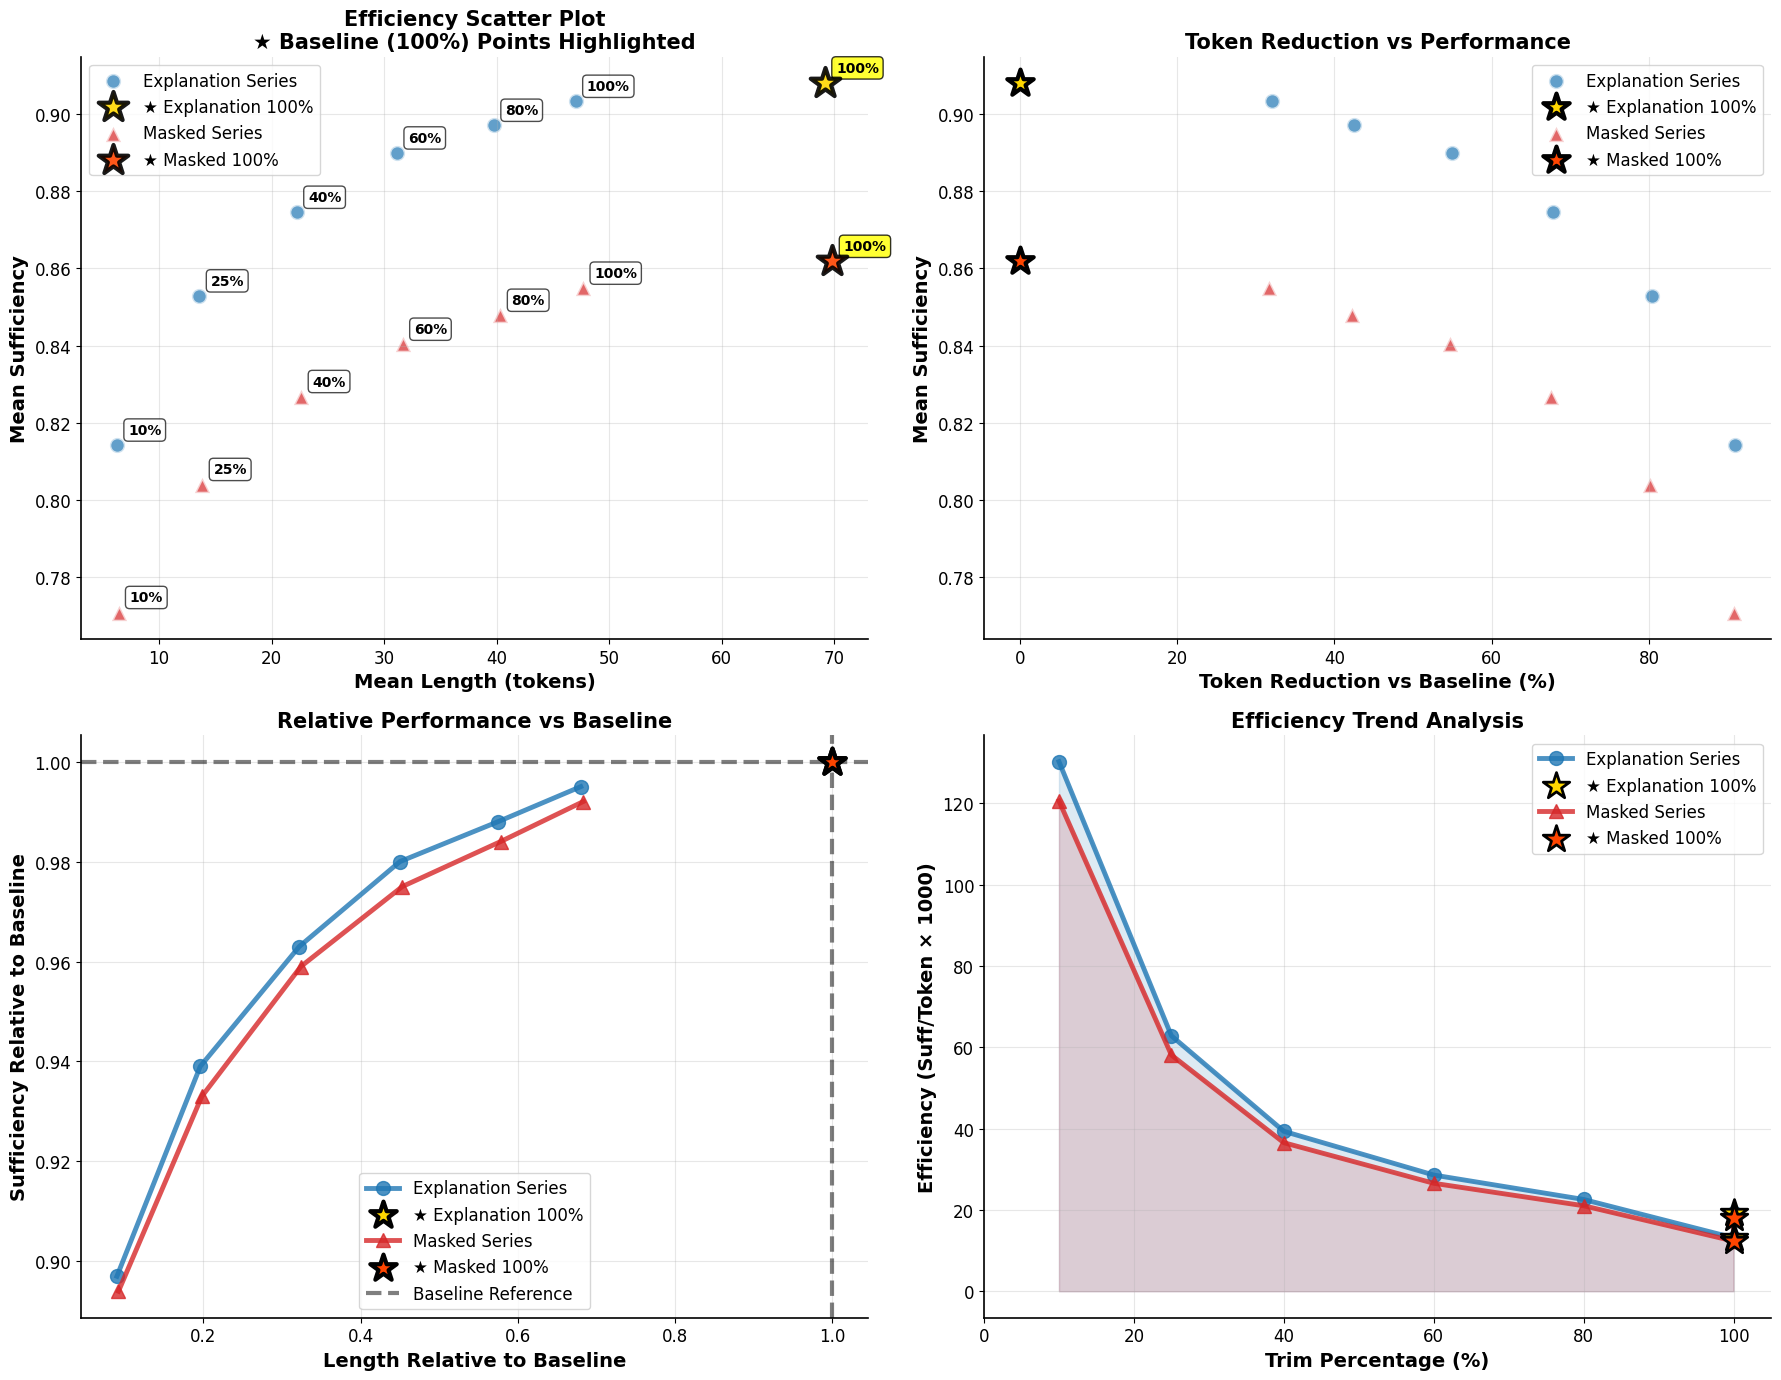


🎓 INFORMATION BOTTLENECK EVALUATION ANALYSIS
📊 Sufficiency vs Conciseness Trade-off Analysis
🔬 Thesis-Style Comprehensive Report

🔵 EXPLANATION SERIES ANALYSIS:
────────────────────────────────────────────────────────────────────────────────────────────────────
★ 100% (BASELINE) │ Sufficiency: 0.9081 │ Length:     69 tokens │ Accuracy: 0.9272
────────────────────────────────────────────────────────────────────────────────────────────────────

🟣 MASKED SERIES ANALYSIS:
────────────────────────────────────────────────────────────────────────────────────────────────────
★ 100% (BASELINE) │ Sufficiency: 0.8618 │ Length:     70 tokens │ Accuracy: 0.8935
────────────────────────────────────────────────────────────────────────────────────────────────────

💡 KEY INSIGHTS & RECOMMENDATIONS:
🏆 Best Explanation Performance:
   ├─ File: baseline.csv
   ├─ Sufficiency: 0.9081
   ├─ Length: 69 tokens
   └─ Accuracy: 0.9272
⚡ Most Efficient Explanation:
   ├─ File: results_explanation_10.csv
   ├─ E

In [30]:
# Execute
def main():
    """Main execution function"""
    print(f"👤 User: alizahedzadeh")
    print(f"📅 Analysis Date: 2025-08-06 11:31:14 UTC")
    print("🧠 Information Bottleneck Analysis - Thesis Style")
    print("★ Enhanced Baseline Visualization - FIXED")
    
    analyzer = IBEvaluationAnalysisThesis(en_path)
    analyzer_obj, summary = analyzer.run_complete_analysis()
    
    return analyzer_obj, summary

if __name__ == "__main__":
    analyzer_en, summary_en = main()

In [ ]:
# Execute
def main():
    """Main execution function"""
    print(f"👤 User: alizahedzadeh")
    print(f"📅 Analysis Date: 2025-08-06 11:31:14 UTC")
    print("🧠 Information Bottleneck Analysis - Thesis Style")
    print("★ Enhanced Baseline Visualization - FIXED")
    
    analyzer = IBEvaluationAnalysisThesis(en_path)
    analyzer_obj, summary = analyzer.run_complete_analysis()
    
    return analyzer_obj, summary

if __name__ == "__main__":
    analyzer_fa, summary_fa = main()